# Deep learning Neural Network Model

In [1]:
from tqdm import tqdm
%matplotlib inline
import re

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)

import json;
import keras;
import keras.preprocessing.text as kpt;
from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import (
    Sequential,
    model_from_json
)
from keras.layers import Dense, Dropout, Activation;


In [36]:
df = pd.read_csv("tweetdata",encoding= 'unicode_escape')

In [37]:
df.shape

(1010508, 5)

In [5]:
df.head()

,Unnamed: 0,Data,Subjectivity,Polarity,Score
0,0,cnsnews benshapiro Can COVID19Vaccine end the ...,0.0,0.0,Neutral
1,1,IntrepidWarrior realDonaldTrump Can COVID19Vac...,0.0,0.0,Neutral
2,2,edyong209 HelenBranswell Can COVID19Vaccine en...,0.0,0.0,Neutral
3,3,AdamTexDavis Can COVID19Vaccine end the pandemic,0.0,0.0,Neutral
4,4,HegKong Can COVID19Vaccine end the pandemic,0.0,0.0,Neutral


In [6]:
df.Score.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [7]:
def getTextAnalysis(a):
    if a > 0:
        return "1"
    else:
        return "0"

In [8]:
df['Score'] = df['Polarity'].apply(getTextAnalysis)

In [9]:
def preprocessing_data(df):
    df['Data'] = df['Data'].str.lower()
    df['Data'] = df['Data'].str.replace('rt', '')
    df['Data'] = df['Data'].replace(r'@\w+', '', regex=True)
    df['Data'] = df['Data'].replace(r'http\S+', '', regex=True)
    df['Data'] = df['Data'].replace(r'www.[^ ]+', '', regex=True)
    df['Data'] = df['Data'].replace(r'[0-9]+', '', regex=True)
    df['Data'] = df['Data'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return df

In [10]:
def in_dict(text):
    if wordnet.synsets(text):
        return True

def replace_elongated_word(text):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(text):
        return text
    new_word = re.sub(regex, repl, text)
    if new_word != text:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(r):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, r)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), r)
    return r

In [11]:
def stop_words(df):
    stop_words_list = stopwords.words('english')
    df['Data'] = df['Data'].str.lower()
    df['Data'] = df['Data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return df

In [12]:
def replace_antonyms(word):
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            if lemma.antonyms(): 
                return lemma.antonyms()[0].name()
    return word

In [13]:
def clean_df(df):
    df = preprocessing_data(df)
    df['Data'] = df['Data'].apply(lambda x: detect_elongated_words(x))

    df = stop_words(df)
    return df

In [14]:
df

,Unnamed: 0,Data,Subjectivity,Polarity,Score
0,0,cnsnews benshapiro Can COVID19Vaccine end the ...,0.000000,0.000000,0
1,1,IntrepidWarrior realDonaldTrump Can COVID19Vac...,0.000000,0.000000,0
2,2,edyong209 HelenBranswell Can COVID19Vaccine en...,0.000000,0.000000,0
3,3,AdamTexDavis Can COVID19Vaccine end the pandemic,0.000000,0.000000,0
4,4,HegKong Can COVID19Vaccine end the pandemic,0.000000,0.000000,0
...,...,...,...,...,...
9995,9995,UAlberta is happy to have you on campus This f...,0.766667,0.600000,1
9996,9996,RT WilsonMHI NEW from MHI Vaccines when approp...,0.488636,0.409091,1
9997,9997,BREAKING Clinical trial for AstraZenecaOxford ...,0.000000,0.000000,0
9998,9998,Supply chain professionals point to the many c...,0.575000,0.125000,1


In [15]:
def vectorization(df):
    vector = CountVectorizer()
    frequency_matrix = vector.fit_transform(df.Data)
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    frequency = np.squeeze(np.asarray(sum_frequencies))
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [16]:
def word_cloud(tweets):
    file = os.getcwd()
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000,  contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["covid19"])
    word_cloud.generate(tweets)
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()


In [17]:
def graph(words, sent):
    target = words[0][1:51].index
    title = "Repeated Words %s" %sent
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), words[0][1:51], width = 0.8, alpha=0.4, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), target, rotation=90, size=14);
    plt.xlabel("50 more repeated words", size=14);
    plt.ylabel("Frequency", size=14);
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

In [18]:
def regression_graph(df):
    df = df[1:]
    sns.set_style("whitegrid")   
    plt.figure(figsize=(6,6))
    points = plt.scatter(df["1"], df["0"], c=df["1"], s=75, cmap="bwr")
    plt.colorbar(points)
    sns.regplot(x="1", y="0",fit_reg=False, scatter=False, color=".1", data=df)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

In [19]:
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(df.Data, df.Score, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test


In [20]:
def tokenization_tweets(data, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(data)
    transformed = tokenization.transform(data).toarray()
    return transformed

In [21]:
def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

In [22]:
tweet_table = clean_df(df)

In [23]:
tweet_table[tweet_table['Score'] == "0"]["Data"]

0            cnsnews benshapiro covidvaccine end pandemic
1       intrepidwarrior realdonaldtrump covidvaccine e...
2         edyong helenbranswell covidvaccine end pandemic
3                  adamtexdavis covidvaccine end pandemic
4                       hegkong covidvaccine end pandemic
                              ...                        
9989    anitaoakville covidvaccinewe added medicagoinc...
9990    anitaoakville covidvaccinewe added medicagoinc...
9991     covid vaccines pass fda requirements covid covid
9997    breaking clinical trial astrazenecaoxford covi...
9999    anitaoakville covidvaccinewe added medicagoinc...
Name: Data, Length: 5054, dtype: object

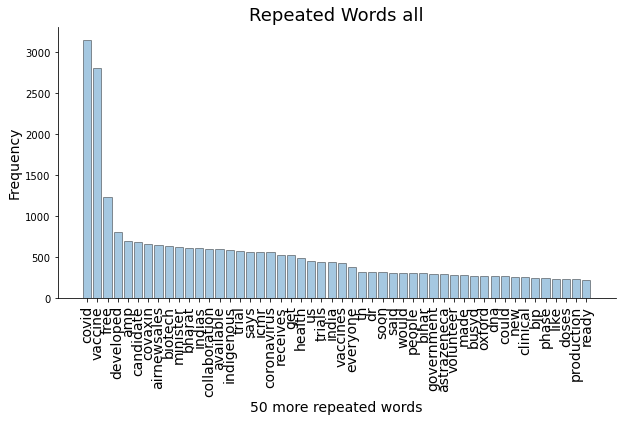

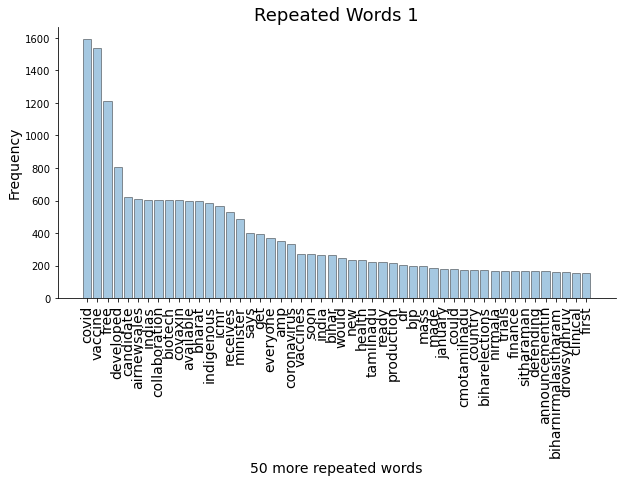

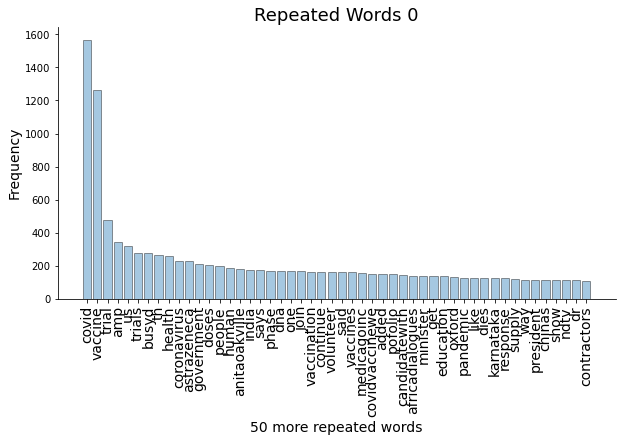

In [24]:
if __name__ == "__main__":
    word_frequency = vectorization(tweet_table).sort_values(0, ascending = False)
    word_frequency_pos = vectorization(tweet_table[tweet_table['Score'] == '1']).sort_values(0, ascending = False)
    word_frequency_neg = vectorization(tweet_table[tweet_table['Score'] == '0']).sort_values(0, ascending = False)
    graph(word_frequency, 'all')
    graph(word_frequency_pos, '1')
    graph(word_frequency_neg, '0')


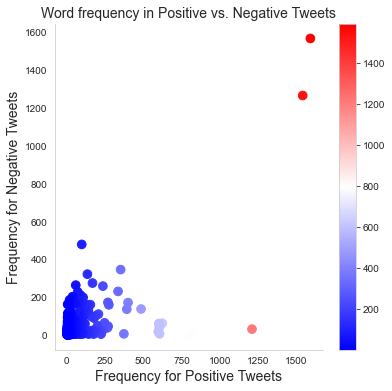

In [25]:
if __name__ == "__main__":
    table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
    table_regression.columns = ["1", "0"]
    regression_graph(table_regression)



In [26]:
if __name__ == "__main__":
    tweet_table = df

In [27]:
if __name__ == "__main__":
    tweet_table['Score'] = tweet_table['Score'].apply(lambda x: 2 if x == '2' else (0 if x == '1' else 1))

In [28]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = splitting(tweet_table)

In [29]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, layer3,layer4,layer5, layer6, layer7, epoch, learning_rate, eps, val):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer3, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer4, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer5, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer6, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer7, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.9999, epsilon=eps, decay=0.0, amsgrad=False)
    model_nn.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=val,
                 shuffle=shuffle)
    return model_nn

In [30]:
def model1(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    layer5 = 112
    layer6 = 56
    layer7 = 16
    epoch = 20
    lr = 0.002
    epsilon = 0.00008
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4,layer5, layer6, layer7, epoch, lr, epsilon, validation)
    return model;
model1(X_train, y_train)

Epoch 1/20
225/225 [==============================] - 7s 30ms/step - loss: 0.7752 - accuracy: 0.3094 - val_loss: 0.7417 - val_accuracy: 0.0000e+00
Epoch 2/20
225/225 [==============================] - 7s 31ms/step - loss: 0.7556 - accuracy: 0.2542 - val_loss: 0.7417 - val_accuracy: 0.0000e+00
Epoch 3/20
225/225 [==============================] - 10s 46ms/step - loss: 0.7549 - accuracy: 0.2525 - val_loss: 0.7417 - val_accuracy: 0.0000e+00
Epoch 4/20
225/225 [==============================] - 7s 30ms/step - loss: 0.7547 - accuracy: 0.2550 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 5/20
225/225 [==============================] - 5s 22ms/step - loss: 0.7546 - accuracy: 0.2447 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 6/20
225/225 [==============================] - 5s 22ms/step - loss: 0.7545 - accuracy: 0.2432 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 7/20
225/225 [==============================] - 5s 23ms/step - loss: 0.7545 - accuracy: 0.2365 - val_loss: 0.74

In [31]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, layer3,layer4,epoch, learning_rate, eps, val):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer3, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer4, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.9999, epsilon=eps, decay=0.0, amsgrad=False)
    model_nn.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=val,
                 shuffle=shuffle)
    return model_nn

In [32]:
def model2(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    epoch = 5
    lr = 0.002
    epsilon = 0.00000001
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4, epoch, lr, epsilon, validation)
    return model;
model2(X_train, y_train)

Epoch 1/5
225/225 [==============================] - 6s 27ms/step - loss: 0.7678 - accuracy: 0.3333 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 2/5
225/225 [==============================] - 6s 25ms/step - loss: 0.7547 - accuracy: 0.3181 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 3/5
225/225 [==============================] - 6s 26ms/step - loss: 0.7545 - accuracy: 0.3151 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 4/5
225/225 [==============================] - 6s 26ms/step - loss: 0.7545 - accuracy: 0.3200 - val_loss: 0.7416 - val_accuracy: 0.0000e+00
Epoch 5/5
225/225 [==============================] - 6s 28ms/step - loss: 0.7545 - accuracy: 0.3260 - val_loss: 0.7416 - val_accuracy: 0.0000e+00


In [33]:
def model3(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    epoch = 15
    lr = 0.009
    epsilon = 0.001
    validation = 0.2
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4, epoch, lr, epsilon, validation)
    return model;
model3(X_train, y_train)

Epoch 1/15
200/200 [==============================] - 5s 27ms/step - loss: 0.7792 - accuracy: 0.3298 - val_loss: 0.7556 - val_accuracy: 0.4950
Epoch 2/15
200/200 [==============================] - 6s 30ms/step - loss: 0.7531 - accuracy: 0.3308 - val_loss: 0.7555 - val_accuracy: 0.4950
Epoch 3/15
200/200 [==============================] - 4s 19ms/step - loss: 0.7527 - accuracy: 0.3264 - val_loss: 0.7555 - val_accuracy: 0.0000e+00
Epoch 4/15
200/200 [==============================] - 5s 25ms/step - loss: 0.7526 - accuracy: 0.3267 - val_loss: 0.7555 - val_accuracy: 0.5050
Epoch 5/15
200/200 [==============================] - 4s 22ms/step - loss: 0.7526 - accuracy: 0.3325 - val_loss: 0.7555 - val_accuracy: 0.5050
Epoch 6/15
200/200 [==============================] - 5s 25ms/step - loss: 0.7526 - accuracy: 0.3319 - val_loss: 0.7555 - val_accuracy: 0.0000e+00
Epoch 7/15
200/200 [==============================] - 4s 22ms/step - loss: 0.7526 - accuracy: 0.3267 - val_loss: 0.7555 - val_accuracy

In [34]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, layer3,layer4,layer5, layer6, layer7, epoch, learning_rate, eps, val):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer3, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer4, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer5, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer6, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer7, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.9999, epsilon=eps, decay=0.0, amsgrad=False)
    model_nn.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=val,
                 shuffle=shuffle)
    return model_nn

In [35]:
def model4(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 540
    layer2 = 532
    layer3 = 256
    layer4 = 230
    layer5 = 112
    layer6 = 56
    layer7 = 10
    epoch = 10
    lr = 0.002
    epsilon = 0.00000001
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4,layer5,layer6, layer7, epoch, lr, epsilon, validation)
    return model;
model4(X_train, y_train)

Epoch 1/10
225/225 [==============================] - 4s 20ms/step - loss: 0.7676 - accuracy: 0.3190 - val_loss: 0.7418 - val_accuracy: 0.5150
Epoch 2/10
225/225 [==============================] - 4s 18ms/step - loss: 0.7552 - accuracy: 0.3722 - val_loss: 0.7417 - val_accuracy: 0.4850
Epoch 3/10
225/225 [==============================] - 4s 20ms/step - loss: 0.7548 - accuracy: 0.3676 - val_loss: 0.7417 - val_accuracy: 0.4850
Epoch 4/10
225/225 [==============================] - 5s 21ms/step - loss: 0.7546 - accuracy: 0.3601 - val_loss: 0.7416 - val_accuracy: 0.4850
Epoch 5/10
225/225 [==============================] - 6s 26ms/step - loss: 0.7546 - accuracy: 0.3535 - val_loss: 0.7416 - val_accuracy: 0.4850
Epoch 6/10
225/225 [==============================] - 5s 22ms/step - loss: 0.7545 - accuracy: 0.3567 - val_loss: 0.7416 - val_accuracy: 0.4850
Epoch 7/10
225/225 [==============================] - 5s 23ms/step - loss: 0.7545 - accuracy: 0.3654 - val_loss: 0.7416 - val_accuracy: 0.4850